
The residual is a fractal noise with 1/f spectrum. Let's us that fact to see if we can get better fits.


https://en.wikipedia.org/wiki/Power_law
https://en.wikipedia.org/wiki/Benoit_Mandelbrot
https://scholar.google.com/citations?user=vZA2pjwAAAAJ&hl=en
http://www.scholarpedia.org/article/1/f_noise
http://www.casinapioiv.va/content/dam/accademia/pdf/acta18/acta18-battro.pdf



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# extracting data and doing the fit on velocity

In [2]:
from ANEMO.edfreader import read_edf

import pickle
with open('../demo/result/param_Fit_AM.pkl', 'rb') as fichier:
    param = pickle.load(fichier, encoding='latin1')
with open('../demo/data/enregistrement_AM_2017-10-23_100057.pkl', 'rb') as fichier:
    file_exp = pickle.load(fichier, encoding='latin1')

datafile = '../demo/data/enregistrement_AM_2017-10-23_100057.asc'
file_data = read_edf(datafile, 'TRIALID')

To see:
https://github.com/bicv/SLIP/blob/master/SLIP/SLIP.py#L674

`` pip3 install SLIP ``


In [3]:
N_freq = 1301

if False:
    from SLIP import Image

    im = Image()
    im.set_size((1, 1301))
    
else:

    
    def whitening_filt(N_freq, white_f_0, white_alpha, white_steepness):
        """
        Returns the envelope of the whitening filter.

            then we return a 1/f spectrum based on the assumption that the structure of signals
            is self-similar and thus that the Fourier spectrum scales a priori in 1/f.
            
        """
        freq = np.fft.fftfreq(N_freq, d=1.)
        K = np.abs(freq)**(white_alpha)
        K *= np.exp(-(np.abs(freq)/white_f_0)**white_steepness)
        K /= np.mean(K)
        
        return freq, K

    def whitening(position, white_f_0=.4, white_alpha=1., white_steepness=4):
        """
        Returns the whitened image
        """
        N_freq = position.shape[0]
        freq, K = whitening_filt(N_freq=N_freq, white_f_0=white_f_0, white_alpha=white_alpha, white_steepness=white_steepness)        
        f_position = np.fft.fft(position)
        return np.real(np.fft.ifft(f_position*K))
    

freq, K = whitening_filt(N_freq=N_freq, white_f_0=.4, white_alpha=1., white_steepness=4)
print('min max freq', freq.min(), freq.max())
print('K.shape', K.shape)    
print('min max K', K.min(), K.max())

min max freq -0.49961568024596464 0.49961568024596464
K.shape (1301,)
min max K 0.0 1.596797218205174


bruit blanc: on a seulement un filtrage passe bas

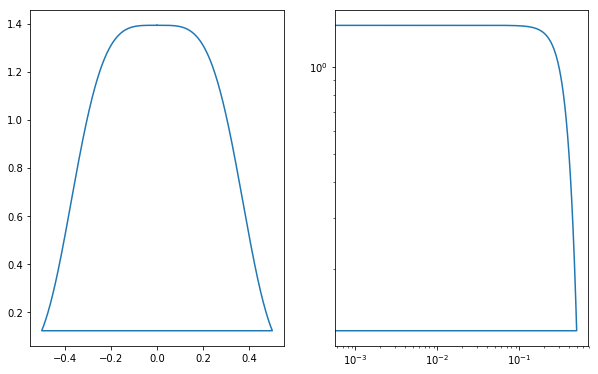

In [4]:
fig_width= 10
fig, axs = plt.subplots(1, 2, figsize=(fig_width, (fig_width)/1.6180))
freq, K = whitening_filt(N_freq, white_f_0=.4, white_alpha=0, white_steepness=4)

axs[0].plot(freq, K)
axs[1].loglog(freq, K);

bruit rouge:

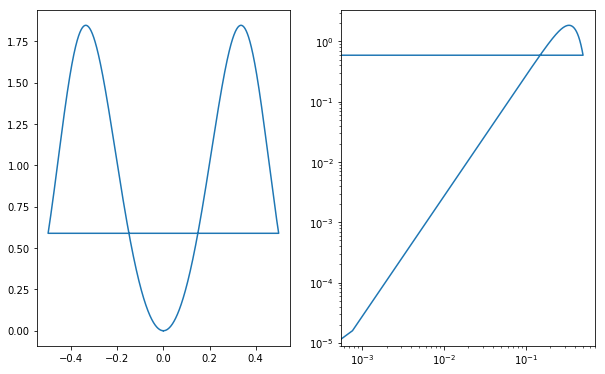

In [5]:
fig_width= 10
fig, axs = plt.subplots(1, 2, figsize=(fig_width, (fig_width)/1.6180))
freq, K = whitening_filt(N_freq, white_f_0=.4, white_alpha=2, white_steepness=4)

axs[0].plot(freq, K)
axs[1].loglog(freq, K);

In [6]:
def deco(axs) :
    axs.axvspan(arg.StimulusOn-start, arg.StimulusOf-start, color='k', alpha=0.2)
    axs.axvspan(arg.StimulusOf-start, arg.TargetOn-start, color='r', alpha=0.2)
    axs.axvspan(arg.TargetOn-start, arg.TargetOff-start, color='k', alpha=0.15)
    for s in range(len(arg.saccades)) :
        axs.axvspan(arg.saccades[s][0]-start, arg.saccades[s][1]-start, color='k', alpha=0.2)

In [7]:
def saccade(x, x_0, tau, x1, x2, T0, t1, t2, tr, do_whitening=True):
    
    time = x-T0
    T1 = t1
    T2 = t1+t2
    TR = T2+tr
    
    rho = (tau/T1) * np.log((1+np.exp(T1/tau))/2)
    rhoT = int(np.round(T1*rho))
    
    r = (tau/T2) * np.log((np.exp(T1/tau) + np.exp(T2/tau)) /2)
    rT = int(np.round(T2*r))
    Umax1 = (1/tau) * x1 / ((2*rho-1)*T1 - tau*(2-np.exp(-(rho*T1)/tau) - np.exp((1-rho)*T1/tau)))
    Umax2 = (1/tau) * (x2-x1) / ((2*r-1)*T2-T1)

    xx = []
    
    for t in time :
        if t < 0 :
            xx.append(x_0)
        elif t < rhoT :
            xx.append((x_0 +      Umax1*tau * ((t)    - tau*(1-np.exp(-t/tau)))))
        elif t < T1 :
            xx.append(x_0 + (x1 + Umax1*tau * ((T1-t) + tau*(1-np.exp((T1-t)/tau)))))
        elif t < rT :
            xx.append(x_0 + (x1 + Umax2*tau * ((t-T1) - tau*(1-np.exp(-(t-T1)/tau)))))
        elif t < TR :
            xx.append(x_0 + (x2 + Umax2*tau * ((T2-t) + tau*(1-np.exp((T2-t)/tau)))))
        else :
            xx.append(xx[-1])
    if do_whitening:
        xx = np.array(xx)

        xx = whitening(xx)
    return xx

In [8]:
def position(x, bino, start_anti, a_anti, latency, tau, maxi, avant, apres, do_whitening=True):
    
    #gradient_deg = gradient_x * 1/px_per_deg * 1000 # gradient en deg/sec
    ms = 1000
    a_anti = (a_anti/1000) #/ms # pour passer de sec à ms
    maxi = maxi /ms
    
    speed = ANEMO.Fct_velocity(x, (bino*2)-1, start_anti, a_anti, latency, tau, maxi)
    pos = np.cumsum(speed)

    for sacc in arg.saccades :
        if sacc[0]-t_0 > int(latency) :
            if int(sacc[1]-t_0)+apres < len(pos) :
                # [starttime, endtime, duration, startx, starty, endx, endy]
                pos[int(sacc[0]-t_0)-avant:int(sacc[1]-t_0)+apres] = pos[int(sacc[0]-t_0)-avant-1]  #np.nan 
                pos[int(sacc[1]-t_0)+apres:] += ((data_x[int(sacc[1]-t_0)+apres]-data_x[int(sacc[0]-t_0)-avant-1])/ arg.px_per_deg) - np.mean(speed[int(sacc[0]-t_0):int(sacc[1]-t_0)]) * sacc[2]
                
            else :
                if int(sacc[0]-t_0)-avant < len(pos) :
                    pos[int(sacc[0]-t_0)-avant:] = pos[int(sacc[0]-t_0)-avant-1]  #np.nan 

    if do_whitening:
        pos = whitening(pos)
    return pos

# doing the fit

In [9]:
def Fit_position(velocity_x, trackertime, bino, TargetOn, 
                 StimulusOf, saccades, avant=0, apres=15,
                 param_fit=None, sup=True, time_sup=-280, step=2, do_whitening=True) :
    

    from lmfit import  Model, Parameters

    t_0 = trackertime[0]

    if param_fit is None :
        param_fit={'tau':[15.,13.,80.], 'maxi':[15.,1.,40], 'a_anti':[0.,-100.,100.],
                   'latency':[TargetOn-t_0+100, TargetOn-t_0+75,'STOP'],
                   'start_anti':[TargetOn-t_0-100, StimulusOf-t_0-200, TargetOn-t_0+75]} #'a_anti':[0.,-40.,40.]

    if param_fit['latency'][2]=='STOP' :
        stop_latency = []
        for s in range(len(saccades)) :
            if (saccades[s][0]-t_0) >= (TargetOn-t_0+100) :
                stop_latency.append((saccades[s][0]-t_0))
        if stop_latency==[] :
            stop_latency.append(len(trackertime))
        stop = stop_latency[0]
    else :
        stop = param_fit['latency'][2]


    if sup==True :
        velocity_x = velocity_x[:time_sup]
        trackertime = trackertime[:time_sup]
    
    if do_whitening:
        velocity_x = whitening(velocity_x)
        
    model = Model(position)

    params = Parameters()

    if step == 1 :
        vary = True
    elif step == 2 :
        vary = False

    params.add('bino', value=bino, vary=False)
    params.add('avant', value=avant, vary=False)
    params.add('apres', value=apres, vary=False)
    
    params.add('maxi', value=param_fit['maxi'][0], min=param_fit['maxi'][1], max=param_fit['maxi'][2])
    params.add('latency', value=param_fit['latency'][0], min=param_fit['latency'][1], max=stop)
    params.add('tau', value=param_fit['tau'][0], min=param_fit['tau'][1], max=param_fit['tau'][2], vary=vary)
    params.add('start_anti', value=param_fit['start_anti'][0], min=param_fit['start_anti'][1], max=param_fit['start_anti'][2], vary=vary)
    params.add('a_anti', value=param_fit['a_anti'][0], min=param_fit['a_anti'][1], max=param_fit['a_anti'][2], vary=vary)

    if step == 1 :
        result_deg = model.fit(velocity_x, params, x=np.arange(len(trackertime)), nan_policy='omit')

    elif step == 2 :
        out = model.fit(velocity_x, params, x=np.arange(len(trackertime)), nan_policy='omit')
        out.params['tau'].set(vary=True)
        out.params['start_anti'].set(vary=True)
        out.params['a_anti'].set(vary=True)

        result_deg = model.fit(velocity_x, out.params, x=np.arange(len(trackertime)), method='nelder', nan_policy='omit')
                                
    return result_deg

In [10]:
def Fit_saccade(position_x, do_whitening=True) :

    if do_whitening:
        position_x = whitening(position_x)
        
    from lmfit import  Model, Parameters

    model = Model(saccade)

    params = Parameters()
    params.add('x_0', value=position_x[0], min=position_x[0]-0.1, max=position_x[0]+0.1, vary=False)
    params.add('tau', value=13, min=5, max=40)
    params.add('T0', value=0, min=-15, max=10)
    params.add('t1', value=15, min=10, max=len(position_x)-10)
    params.add('t2', value=12, min=10, max=len(position_x)-10, vary=False)
    params.add('tr', value=1, min=0, max=15, vary=False)
    params.add('x1', value=2, min=-5, max=5)
    params.add('x2', value=1, min=-5, max=5, vary=False)

    out = model.fit(position_x, params, x=np.arange(len(position_x)), nan_policy='omit')
    out.params['x_0'].set(vary=True)
    out.params['t2'].set(vary=True)
    out.params['tr'].set(vary=True)
    out.params['x2'].set(vary=True)

    result_deg = model.fit(position_x, out.params, x=np.arange(len(position_x)), method='nelder', nan_policy='omit')

    #result_deg = model.fit(position_x, params, x=np.arange(len(position_x)), nan_policy='omit')

    return result_deg


# Residu!

In [11]:
from ANEMO import ANEMO
ANEMO = ANEMO(file_exp)

In [12]:
debut, fin = 0, 15

block = 0
#trial = 13

demi_four, demi_freq = [], []
white, four, freq_four = [], [], []

N_freq = 1301
N_trial = 150

for trial in range(N_trial):

    print('trial', trial)

    arg = ANEMO.arg(file_data, trial, block)
    trial_data = trial + arg.N_trials*block
    time, t_0 = arg.trackertime, arg.t_0
    start, start1 = arg.TargetOn, arg.TargetOn-t_0
    data_x = arg.data_x - (arg.data_x[arg.StimulusOf-t_0])

    kwarg = {'trackertime': arg.trackertime, 'bino': arg.bino, 'TargetOn': arg.TargetOn,
             'StimulusOf': arg.StimulusOf, 'saccades': arg.saccades,
             'param_fit': None,  'avant': debut, 'apres': fin,
             'sup': True, 'time_sup': -280, 'step': 2}

    data_1 = np.copy(data_x)/arg.px_per_deg
    data_2 = np.copy(data_1)

    for s in range(len(arg.saccades)):
        data_sacc = data_1[arg.saccades[s][0] -
                           t_0-debut:arg.saccades[s][1]-t_0+fin]
        f = Fit_saccade(data_sacc)
        data_2[arg.saccades[s][0]-t_0-debut:arg.saccades[s]
               [1]-t_0+fin] = f.residual+f.values['x_0']

    c = Fit_position(data_2, **kwarg)
    residu = c.residual[start1-700:start1+(N_freq-700)]

    # -----------------------------------------------------------------------------
    ms = 1000.0  # taux d'échantillonnage
    dt = 1.0/ms  # intervalle d'échantillonnage
    n = len(residu)  # longueur du residu

    k, T = np.arange(n), n/ms
    frq = k/T  # gamme de fréquence de deux côtés

    t = np.arange(0, T, dt)  # vecteur de temps

    N = range(N_freq//2 +1)  # range(int(n/2))

    frq = frq[N]  # une gamme de fréquence latérale
    freq = np.fft.fftfreq(N_freq, d=dt)

    fourier = np.fft.fft(residu)/n  # fft informatique et normalisation

    # -----------------------------------------------------------------------------
    demi_four.append((abs(fourier[N])).tolist())
    four.append(fourier.tolist())
    white.append(fourier.tolist())
    demi_freq.append(frq.tolist())
    freq_four.append(freq.tolist())

trial 0
trial 1
trial 2
trial 3
trial 4
trial 5
trial 6
trial 7
trial 8
trial 9
trial 10
trial 11
trial 12
trial 13
trial 14
trial 15
trial 16
trial 17
trial 18
trial 19
trial 20
trial 21
trial 22
trial 23
trial 24
trial 25
trial 26
trial 27
trial 28
trial 29
trial 30
trial 31
trial 32
trial 33
trial 34
trial 35
trial 36
trial 37
trial 38
trial 39
trial 40
trial 41
trial 42
trial 43
trial 44
trial 45
trial 46
trial 47
trial 48
trial 49
trial 50
trial 51
trial 52
trial 53
trial 54
trial 55
trial 56
trial 57
trial 58
trial 59
trial 60
trial 61
trial 62
trial 63
trial 64
trial 65
trial 66
trial 67
trial 68
trial 69
trial 70
trial 71
trial 72
trial 73
trial 74
trial 75
trial 76
trial 77


ValueError: Parameter 't1' has min == max

In [ ]:
freq = np.fft.fftfreq(1301, d=1.)
print('freq' , freq)
print('min max freq', freq.min(), freq.max())


In [ ]:
len(freq_four), len(demi_four)

In [ ]:
whitening(residu)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, 2*(fig_width)/1.6180))

ax.plot(residu)
ax.plot(whitening(residu))

## Fit Residu Power Law

In [ ]:
from lmfit.models import PowerLawModel

In [ ]:
mean_demi_four = np.mean(demi_four, 0)

mod = PowerLawModel()

pars = mod.guess(mean_demi_four, x=np.arange(len(mean_demi_four)))
out = mod.fit(mean_demi_four, pars, x=np.arange(len(mean_demi_four)), nan_policy='omit')
print(out.fit_report())

In [ ]:
fig_width= 10
fig, axs = plt.subplots(2, 1, figsize=(fig_width, 2*(fig_width)/1.6180))

axs[0].plot(np.mean(demi_freq, 0), np.mean(demi_four, 0), 'k')
axs[0].plot(np.mean(demi_freq, 0),out.best_fit, 'r')

axs[1].loglog(np.mean(demi_freq, 0), np.mean(demi_four, 0), 'k')
axs[1].loglog(np.mean(demi_freq, 0), out.best_fit, 'r');

In [ ]:
freq, K = whitening_filt(N_freq)
print('K.shape', K.shape)

fig_width= 10
fig, axs = plt.subplots(2, 1, figsize=(fig_width, 2*(fig_width)/1.6180))

axs[0].plot(freq, K)
axs[1].loglog(freq, K);